In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid#
import torchvision
import os
import random
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
def build_datasets():

    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    trainset = torchvision.datasets.ImageFolder(root='Breast_cancer_200/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
    validset = torchvision.datasets.ImageFolder(root='Breast_cancer_200/valid', transform=transform)
    validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                         shuffle=True, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='Breast_cancer_200/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

    return trainloader,validloader, testloader



In [6]:
trainloader,validloader, testloader = build_datasets()

In [7]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self, num_classes: int = 8, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.MaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = CNN()
net

CNN(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (maxpool): MaxPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fea

In [8]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def valid(model,iterator):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F
import time

train_l = []
train_a = []
valid_l = []
valid_a = []

if __name__ == '__main__':

    for epoch in range(100):
        start_time = time.monotonic()
        train_loss, train_acc = train(net, trainloader, optimizer, criterion, device)
        valid_loss, valid_acc = valid(net, validloader)
        
        train_l.append(train_loss)
        train_a.append(train_acc)
        valid_l.append(valid_loss)
        valid_a.append(valid_acc)
        
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100:.2f}%')
    print('Finished Training')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network test images: %d %%' % (
            100 * correct / total))

Epoch: 01 | Epoch Time: 1m 53s
	Train Loss: 1.662 | Train Acc: 44.83%
	Valid Loss: 1.792 | Valid Acc: 42.45%
Epoch: 02 | Epoch Time: 1m 54s
	Train Loss: 1.600 | Train Acc: 45.30%
	Valid Loss: 1.824 | Valid Acc: 41.27%
Epoch: 03 | Epoch Time: 1m 57s
	Train Loss: 1.561 | Train Acc: 47.41%
	Valid Loss: 1.812 | Valid Acc: 41.51%
Epoch: 04 | Epoch Time: 1m 55s
	Train Loss: 1.528 | Train Acc: 49.88%
	Valid Loss: 1.757 | Valid Acc: 40.09%
Epoch: 05 | Epoch Time: 1m 51s
	Train Loss: 1.503 | Train Acc: 50.10%
	Valid Loss: 1.745 | Valid Acc: 35.85%
Epoch: 06 | Epoch Time: 1m 50s
	Train Loss: 1.487 | Train Acc: 49.24%
	Valid Loss: 1.807 | Valid Acc: 41.04%
Epoch: 07 | Epoch Time: 1m 53s
	Train Loss: 1.458 | Train Acc: 49.52%
	Valid Loss: 1.696 | Valid Acc: 43.40%
Epoch: 08 | Epoch Time: 1m 27s
	Train Loss: 1.426 | Train Acc: 50.49%
	Valid Loss: 1.753 | Valid Acc: 43.63%
Epoch: 09 | Epoch Time: 1m 11s
	Train Loss: 1.367 | Train Acc: 50.47%
	Valid Loss: 1.724 | Valid Acc: 45.28%
Epoch: 10 | Epoch T

In [ ]:
print(train_a)

In [8]:
classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Adenosis is: 66.7 %
Accuracy for class Ductal_Carcinoma is: 95.5 %
Accuracy for class Fibroadenoma is: 82.7 %
Accuracy for class Lobular_Carcinoma is: 78.8 %
Accuracy for class Mucinous_Carcinoma is: 76.9 %
Accuracy for class Papillary_Carcinoma is: 88.9 %
Accuracy for class Phyllodes_tumor is: 84.2 %
Accuracy for class Tubular_adenoma is: 67.9 %


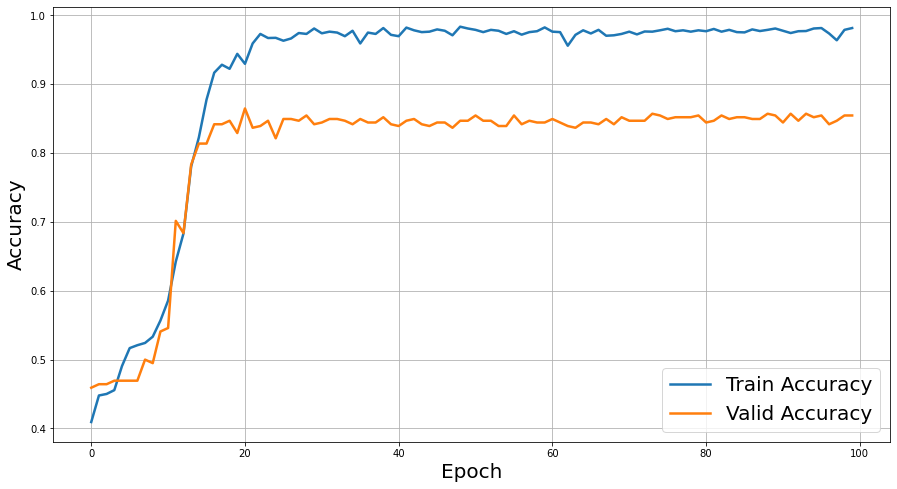

In [28]:
plt.figure(figsize=(15,8))
plt.plot(train_a,label='Train Accuracy',linewidth=2.5)
plt.plot(valid_a,label='Valid Accuracy',linewidth=2.5)
plt.xlabel('Epoch',size=20)
plt.ylabel('Accuracy',size=20)
plt.legend(fontsize = 20)
plt.grid()

In [12]:
import sklearn

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(net, device, testloader)
print('Confusion matrix:')
print(sklearn.metrics.confusion_matrix(actuals, predictions))
print('F1 score: %f' % sklearn.metrics.f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % sklearn.metrics.accuracy_score(actuals, predictions))

Confusion matrix:
[[ 16   8   0   0   0   0   0   0]
 [  0 171   1   1   5   1   0   0]
 [  0   7  43   0   1   0   1   0]
 [  0   7   0  26   0   0   0   0]
 [  0   7   1   0  30   1   0   0]
 [  0   3   0   0   0  24   0   0]
 [  0   2   2   0   1   0  32   1]
 [  0   5   2   1   1   0   0  19]]
F1 score: 0.859524
Accuracy score: 0.859524


In [14]:
a = [[ 16 ,  8 ,  0 ,  0  , 0   ,0  , 0 ,  0],
     [  0 ,171 ,  1  , 1  , 5  , 1  , 0 ,  0],
     [  0  , 7 , 43  , 0  , 1  , 0,   1 ,  0],
     [  0  , 7   ,0 , 26 ,  0  , 0 ,  0   ,0],
     [  0  , 7  , 1  , 0,  30 ,  1 ,  0 ,  0],
     [  0  , 3,   0 ,  0 ,  0 , 24 ,  0,   0],
     [  0   ,2 ,  2,   0 ,  1,   0 , 32 ,  1],
     [  0 ,  5 ,  2  , 1 ,  1,   0 ,  0 , 19]]

b = [[ 16/24,   8/24 ,  0,   0,   0,   0,   0 ,  0],
     [  0 ,171/179,   1/179  , 1/179 ,  5/179 ,  1/179 ,  0 ,  0],
     [  0  , 7/52 , 43/52 ,  0  , 1/52 ,  0 ,  1/52,   0],
     [  0 ,  7/33  , 0 , 26/33  , 0,   0,   0 ,  0],
     [  0   ,7/39  , 1/39  , 0  ,30/39 ,  1/39,   0  , 0],
     [  0 ,  3/27  , 0  , 0 ,  0 , 24/27 ,  0  , 0],
     [  0  , 2/38 ,  2/38,   0 ,  1/38  , 0  ,32/38 ,  1/38],
     [  0  , 5/28 ,  2/28  , 1/28 ,  1/28 ,  0  , 0  ,19/28]]


c = [[ 19 ,  3 ,  1 ,  1  , 0   ,0  , 0 ,  0],    
     [  3 ,159 ,  4  , 1  , 6  , 4  , 2 ,  0],     
     [  0  , 3 , 46  , 0  , 1  , 0,   2 ,  0],     
     [  0  , 3   ,0 , 29 ,  1  , 0 ,  0   ,0],     
     [  0  , 1  , 0  , 1,  35 ,  1 ,  0 ,  1],    
     [  0  , 4,   0 ,  0 ,  0 , 23 ,  0,   0],
     [  0   ,3 ,  0,   0 ,  1,   0 , 34 ,  0],    
     [  0 ,  4 ,  0  , 0 ,  1,   0 ,  0 , 19]]

d = [[ 19/24,   3/24 ,  1/24,   1/24,   0,   0,   0 ,  0],     
     [  3/179 ,159/179,   4/179  , 1/179 ,  6/179 ,  4/179 ,  2/179 ,  0],     
     [  0  , 3/52 , 46/52 ,  0  , 1/52 ,  0 ,  2/52,   0],     
     [  0 ,  3/33  , 0 , 29/33  , 1/33,   0,   0 ,  0],
     [  0   ,1/39  , 0  , 1/39  ,35/39 ,  1/39,   0  , 1/39],    
     [  0 ,  4/27  , 0  , 0 ,  0 , 23/27 ,  0  , 0],
     [  0  , 3/38 ,  0,   0 ,  1/38  , 0  ,34/38 ,  0],    
     [  0  , 3/28 ,  0  , 0 ,  1/28 ,  0  , 0  ,24/28]]



<AxesSubplot:title={'center':'confusion Matrix x200 ohne Augmentation'}>

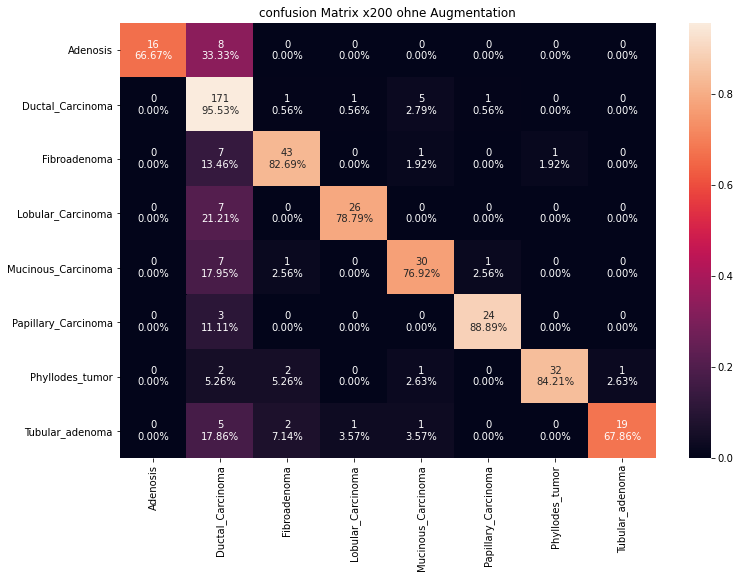

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

group_counts = ["{0:0.0f}".format(value) for value in
                np.array(a).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     np.array(b).flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

categories = ['Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma']

plt.figure(figsize = (12,8))
plt.title('confusion Matrix x200 ohne Augmentation')
sns.heatmap(b, annot = labels, fmt='', xticklabels = categories, yticklabels = categories)

<AxesSubplot:title={'center':'confusion Matrix x200 mit Data Augmentation'}>

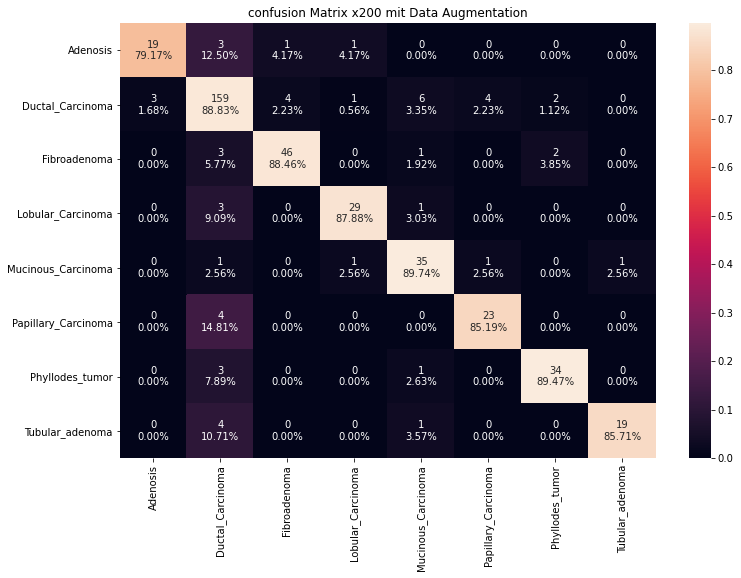

In [17]:
group_counts = ["{0:0.0f}".format(value) for value in
                np.array(c).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     np.array(d).flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

categories = ['Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma']

plt.figure(figsize = (12,8))
plt.title('confusion Matrix x200 mit Data Augmentation')
sns.heatmap(d, annot = labels, fmt='', xticklabels = categories, yticklabels = categories)



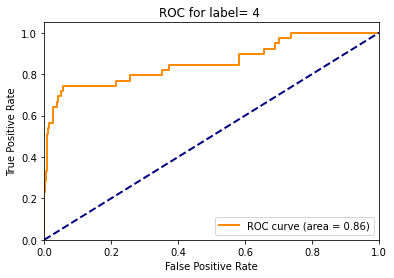

In [16]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 4
actuals, class_probabilities = test_class_probabilities(net, device, testloader, which_class)

fpr, tpr, _ = sklearn.metrics.roc_curve(actuals, class_probabilities)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label= %d ' % which_class)
plt.legend(loc="lower right")
plt.show()

In [18]:
print(valid_a)

[0.42452830188679247, 0.41273584905660377, 0.41509433962264153, 0.4009433962264151, 0.3584905660377358, 0.41037735849056606, 0.4339622641509434, 0.4363207547169811, 0.4528301886792453, 0.5306603773584906, 0.5754716981132075, 0.6721698113207547, 0.7311320754716981, 0.7830188679245284, 0.8089622641509434, 0.8466981132075472, 0.8490566037735849, 0.8561320754716981, 0.8514150943396226, 0.8655660377358491, 0.8419811320754716, 0.8325471698113207, 0.8349056603773585, 0.8514150943396226, 0.839622641509434, 0.8608490566037735, 0.8584905660377359, 0.8632075471698113, 0.8632075471698113, 0.8584905660377359, 0.8561320754716981, 0.8466981132075472, 0.8537735849056604, 0.8726415094339622, 0.8419811320754716, 0.8466981132075472, 0.8608490566037735, 0.8490566037735849, 0.8514150943396226, 0.8561320754716981, 0.8632075471698113, 0.8561320754716981, 0.8514150943396226, 0.8655660377358491, 0.8655660377358491, 0.8632075471698113, 0.8561320754716981, 0.8537735849056604, 0.8514150943396226, 0.84905660377358